In [34]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [35]:
num_evs = 5
num_time_steps = 24  
e = np.array([50, 10, 50, 50, 10])  # Energy requests in kWh
V = 240  # Voltage in volts
dt = 0.5  # Time step duration in hours
max_total_power = 30  # Maximum total power in kW
arrival_times = np.array([0, 3, 4, 6, 7])
departure_times = np.array([10, 20, 23, 19, 21])

In [36]:
def optimize_power_schedule(e, V, dt, max_total_power, num_evs, num_time_steps, arrival_times, departure_times):
    # Decision variable: charging current for each EV at each time step
    r = cp.Variable((num_evs, num_time_steps), nonneg=True)

    # Compute delivered energy for each EV in kWh
    delivered_energy = cp.sum(r, axis=1) * V * dt / 1000

    # Compute energy deviation for each EV
    energy_deviation = delivered_energy - e

    # Fast charging incentive: penalize later charging times
    time_penalty = np.arange(num_time_steps).reshape(1, -1)
    fast_charging_incentive = cp.sum(cp.multiply(r, time_penalty))

    # Combined objective function
    objective = cp.Minimize(cp.sum_squares(energy_deviation) + 0.001 * fast_charging_incentive)

    # Constraints
    constraints = [
        cp.sum(r, axis=0) * V / 1000 <= max_total_power,    # Do not exceed the total capacity
        delivered_energy <= e,                  # Do not exceed requested energy
        r <= 64
    ]

    # Time constraints for each EV
    for i in range(num_evs):
        if arrival_times[i] > 0:
            constraints.extend([r[i, t] == 0 for t in range(arrival_times[i])])  # No charging before arrival
        if departure_times[i] < num_time_steps:
            constraints.extend([r[i, t] == 0 for t in range(departure_times[i], num_time_steps)])  # No charging after departure

    # Define and solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return r.value

In [37]:
optimized_schedule = optimize_power_schedule(e, V, dt, max_total_power, num_evs, num_time_steps, arrival_times, departure_times)

# Display the results
print("Optimized Charging Schedule (Amperes):")
print(np.round(optimized_schedule, 2))

# Calculate and print the actual delivered energy
delivered_energy = np.sum(optimized_schedule, axis=1) * V * dt / 1000  # Convert to kWh
print("\nDelivered Energy (kWh):")
print(np.round(delivered_energy, 2))

print("\nRequested Energy (kWh):")
print(e)

print(f"\nTotal Energy Used: {np.sum(delivered_energy):.2f} kWh")
print(f"Maximum Total Power: {max_total_power} kW")

Optimized Charging Schedule (Amperes):
[[6.400e+01 6.400e+01 6.400e+01 6.371e+01 6.086e+01 6.068e+01 1.447e+01
  8.320e+00 8.180e+00 8.020e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 6.129e+01 1.560e+00 9.300e-01 1.100e-01
  7.000e-02 7.000e-02 6.000e-02 3.650e+00 8.890e+00 6.300e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.258e+01 6.339e+01 4.770e+01
  4.042e+01 4.049e+01 4.054e+01 4.928e+01 4.398e+01 2.787e+01 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.272e+01
  5.642e+01 5.623e+01 5.601e+01 6.372e+01 6.372e+01 5.743e+01 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+0

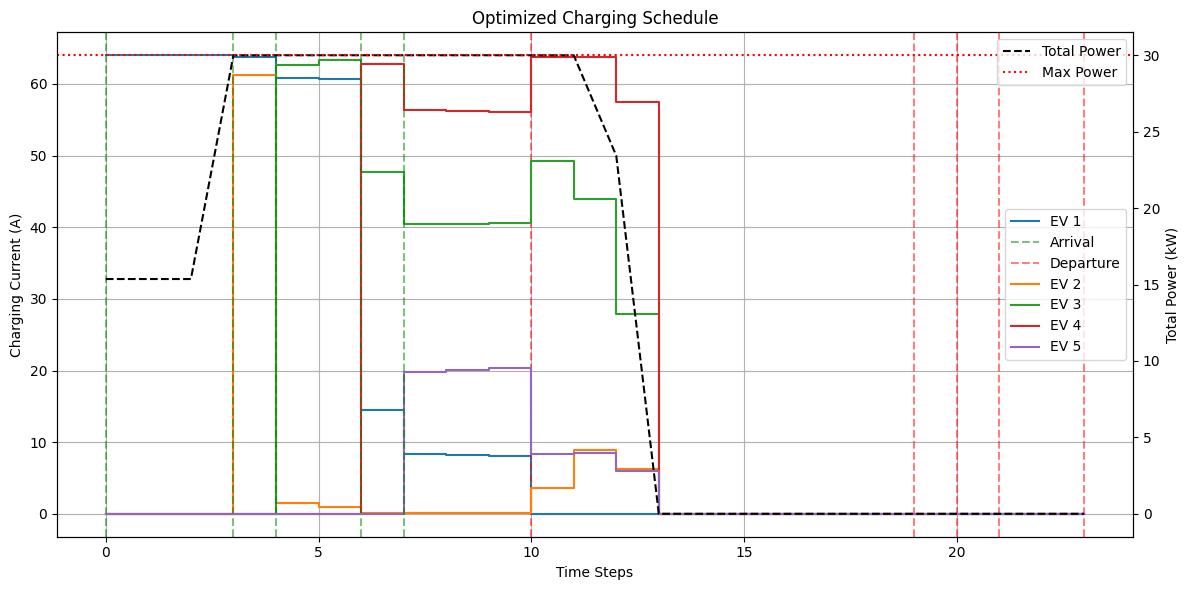

In [38]:
def plot_charging_schedule(optimized_schedule, num_time_steps, arrival_times, departure_times, max_power, V):
    plt.figure(figsize=(12, 6))
    for i in range(optimized_schedule.shape[0]):
        plt.step(range(num_time_steps), optimized_schedule[i], label=f'EV {i+1}', where='post')
        plt.axvline(x=arrival_times[i], color='g', linestyle='--', alpha=0.5, label='Arrival' if i == 0 else "")
        plt.axvline(x=departure_times[i], color='r', linestyle='--', alpha=0.5, label='Departure' if i == 0 else "")

    plt.xlabel('Time Steps')
    plt.ylabel('Charging Current (A)')
    plt.title('Optimized Charging Schedule')
    plt.legend(loc='right')
    plt.grid(True)

    total_power = np.sum(optimized_schedule, axis=0) * V / 1000 # Convert to kW
    plt.twinx()
    plt.plot(range(num_time_steps), total_power, 'k--', label='Total Power')
    plt.ylabel('Total Power (kW)')
    plt.axhline(y=max_power, color='r', linestyle=':', label='Max Power')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the optimized charging schedule
plot_charging_schedule(optimized_schedule, num_time_steps, arrival_times, departure_times, max_total_power, V)